In [29]:
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd
from glob import glob
from pathlib import Path
import os
import numpy as np

In [30]:
def load_tensorboard_events(logdir):
    event_acc = EventAccumulator(logdir)
    event_acc.Reload()

    # Getting all the data from the TensorBoard file
    scalar_tags = event_acc.Tags()['scalars']

    data = {}
    for tag in scalar_tags:
        # Get the data for each tag
        events = event_acc.Scalars(tag)
        steps = [event.step for event in events]
        values = [event.value for event in events]
        data[tag] = {'steps': steps, 'values': values}

    return data

def get_iqm(sub_folder_path):
    algos = ['dgum', 'ddpg', 'td3']

    sf_path = Path(sub_folder_path)

    env_id = sf_path.name

    result_dict = {}

    for algo in algos:
        print(algo)
        event_paths = sorted(glob(os.path.join(sf_path,f"*{algo}_cont*","events.out*")))
        print(event_paths)

        # if no files found then just continue
        if len(event_paths) == 0:
            continue

        steps = None
        ep_returns = [] # list of list of returns
        iqm = []
        
        for ev_path in event_paths:
            data = load_tensorboard_events(ev_path)['eval/training_avg']
            if steps is None:
                steps = data['steps']
            
            ep_returns.append(data['values'])
        
        ep_returns = np.array(ep_returns).T

        print(ep_returns.shape)
        

        for step in ep_returns:
            iqm.append(interquartile_mean(step))

        
        result_dict[algo] = {
            "step": steps,
            "iqm": iqm
        }
    
    return result_dict

def interquartile_mean(arr):
    # Sort the array
    sorted_arr = np.sort(arr)
    
    # Get the length of the array
    arr_len = len(sorted_arr)
    
    # Calculate the start and end indices for the middle half values
    start_index = arr_len // 4
    end_index = 3 * arr_len // 4
    
    # Get the middle half values
    middle_half = sorted_arr[start_index:end_index]
    
    return middle_half.mean()

def plot_iqms(results):
    for key, data in results.items():
        fig, ax = plt.subplots()

        ax.plot(data['step'],data['iqm'])

        ax.set_xlabel("Training Step")
        ax.set_ylabel("IQM Episodic Returns")
        ax.set_title(f"Evaluation for {key}")

        fig.show()

In [31]:
res = get_iqm("../runs/Ant-v4")

dgum
['../runs/Ant-v4/Ant-v4__dgum_continuous_action__235__1714505544/events.out.tfevents.1714505544.della-i14g3.1503102.0', '../runs/Ant-v4/Ant-v4__dgum_continuous_action__37__1714453205/events.out.tfevents.1714453205.della-i14g3.1443208.0']
(1000, 2)
ddpg
['../runs/Ant-v4/Ant-v4__ddpg_continuous_action__235__1714516613/events.out.tfevents.1714516613.della-i14g3.1517327.0', '../runs/Ant-v4/Ant-v4__ddpg_continuous_action__37__1714464197/events.out.tfevents.1714464197.della-i14g3.1455695.0']
(1000, 2)
td3
['../runs/Ant-v4/Ant-v4__td3_continuous_action__235__1714524111/events.out.tfevents.1714524111.della-i14g3.1525503.0', '../runs/Ant-v4/Ant-v4__td3_continuous_action__37__1714472575/events.out.tfevents.1714472575.della-i14g3.1465476.0']
(1000, 2)


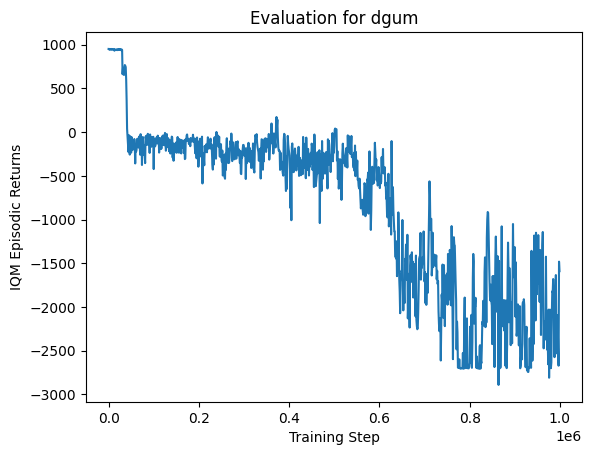

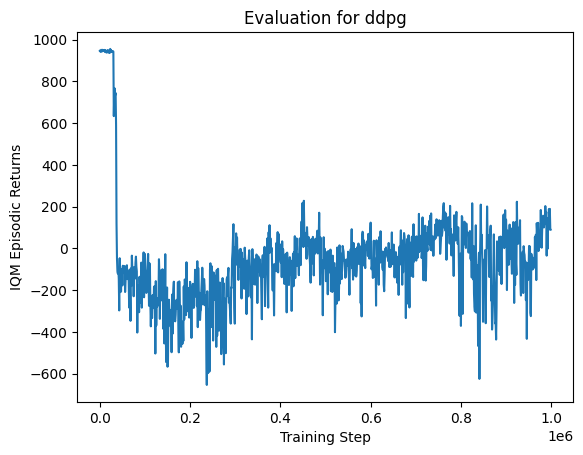

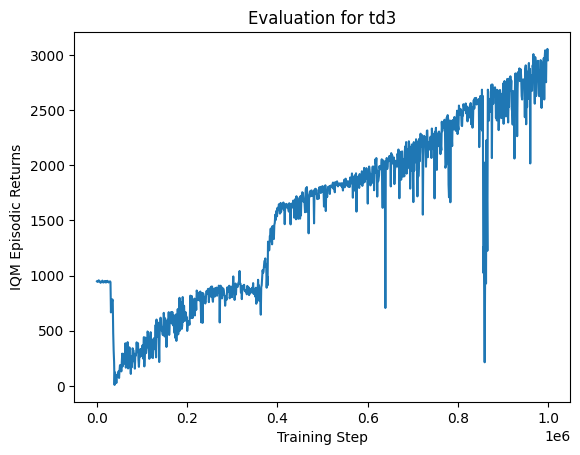

In [32]:
plot_iqms(res)